# AgCaP
<br>

**Conceptualization, Methodology:** [Davide Mazzoni](https://github.com/orgs/SEforALL-IEAP/people/davidemazzoni2) <br> **Code:** [Alexandros Korkovelos](https://github.com/akorkovelos)<br> **Supervision, Review and Advisory support:** xx<br> **Funding:** SeforALL

--------------------------
This is the AgCap notebook.The main purpose of this notebook is to .... Using this notebook the user will be able to change however many datasets needed.

In order to run the analysis the following datasets are needed:
* [Population clusters (settlements)](https://data.grid3.org/datasets/GRID3::grid3-moz-settlement-extents-v2-0/explore) 
* [Population](https://data.humdata.org/dataset/gridded-population-estimates-for-mozambique-2017-census-v1-1?)  
* [Cropland extent](https://glad.umd.edu/dataset/croplands) 
* [Livelihood zones](https://fews.net/mozambique-livelihood-zones-2014) 
* [Food insecurity](https://fews.net/data/acute-food-insecurity?field_data_node_dates_end_value=&date=&region%5B%5D=547) 
* [Satellite nightlights](https://eogdata.mines.edu/products/vnl/) 
* [Coastline](https://www.soest.hawaii.edu/pwessel/gshhg/) 
* [Railway stations](OSM extraction) 
* [Airports](OSM extraction)
* [Ports](OSM extraction)
* [Security risk (conflicts)](https://acleddata.com/data-export-tool/)
* Drought risk
* Flood risk
* Heat waves risk
* Road network
* [Water frequency](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_GlobalSurfaceWater)
* [Livestock](https://dataverse.harvard.edu/dataverse/glw_4)
* [Admin boundaries](https://gadm.org/)
* [Air temperature at 2m (dry bulb)](https://solargis.com/maps-and-gis-data/download)

Below instructions for each cell follows.


## Importing necessary packages (Mandatory)

Packages to be used are imported from the funcs.ipynb.

In [1]:
from ipynb.fs.full.funcs import *

C:\Users\alexl\Dropbox\GitHub\AgCAP\funcs.ipynb:733: SyntaxWarning: "is" with a literal. Did you mean "=="?
  },
C:\Users\alexl\Dropbox\GitHub\AgCAP\funcs.ipynb:735: SyntaxWarning: "is" with a literal. Did you mean "=="?
  "cell_type": "code",


In [62]:
## Import python modules
#import geopandas as gpd
#import pandas as pd
#import pyproj
#import numpy as np
#
#from functools import reduce
#import shapely
#from shapely.geometry import Point, Polygon, MultiPoint
#from shapely.ops import nearest_points
#
#from sklearn.neighbors import BallTree
#
##import datapane as dp
##!datapane login --token=9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8
#
#import folium
#from folium.features import GeoJsonTooltip
#folium.__version__ = '0.12.0'                 ## Had to manually set the version as not available when package installed
#import branca.colormap as cm
#import os
#from IPython.display import display, Markdown, HTML, FileLink, FileLinks

import matplotlib.pyplot as plt
#from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import MinMaxScaler

#import datetime

#%matplotlib inline

## Setting the target coordinate system (Mandatory)

When calculating distances it is important to choose a coordinate system that represents distances correctly in your area of interst. The coordinate system that is given below is the World Mercator, these coordinate system works well for Sub Saharan Africa but the distortions get larger as you move away from the equator.

In order to select your own coordinate system go to [epsg.io](http://epsg.io/) and type in your area of interest, this will give you a list of coordinate systems to choose from. Once you have selected your coordinate system replace the numbers below with the numbers from your coordinate system **(keep the "EPSG" part)**.

**NOTE** When selecting your coordinate system make sure that you select a system with the unit of meters, this is indicated for all systems on [epsg.io](http://epsg.io/)

In [3]:
## Coordinate and projection systems
crs_WGS84 = pyproj.CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = pyproj.CRS("EPSG:32637")    # Projection system for the selected country -- see http://epsg.io/ for more info

## Define workspace and main directories

Define the workspace. The output layers will populate this folder. It is highly recommended to select an empty folder as your workspace.

In [4]:
ROOT_DIR = os.path.abspath(os.getcwd())
in_path = ROOT_DIR + "\\" + 'GIS_data'
workspace = ROOT_DIR + "\\" + "Output"

In [5]:
#messagebox.showinfo('Cooling module', 'Output folder')
#workspace = filedialog.askdirectory()

## Importing admin boundary as geodataframe
For the administrative boundaries you will have to select an **Polygon** layer represeting your area of interest.

In [6]:
# Define path and name of the file
admin_path = in_path + "\\" + "Admin"
admin_name = "moz_admin1.gpkg"

In [7]:
# Create a new geo-dataframe
admin_gdf = gpd.read_file(admin_path + "\\" + admin_name)
test_admin_gdf = gpd.read_file(admin_path + "\\" + admin_name) ### This is just for the test case study (MV and TRX extraction)
##Activate this if you want to clip part of the AoI e.g., for testing
admin_gdf = admin_gdf[admin_gdf.ADM2_NAME == "Mopeia"]


## Add buffer for clipping
## cap_style refers to the type of geometry generated; 3=rectangular (see shapely documectation for more info -- https://shapely.readthedocs.io/en/stable/manual.html)
admin_gdf_buf = admin_gdf.copy()
admin_gdf_buf['geometry'] = admin_gdf_buf.apply(lambda x:
                                        x.geometry.buffer(0.008, cap_style=3), axis=1)  ### 0.008 deg = ~1km

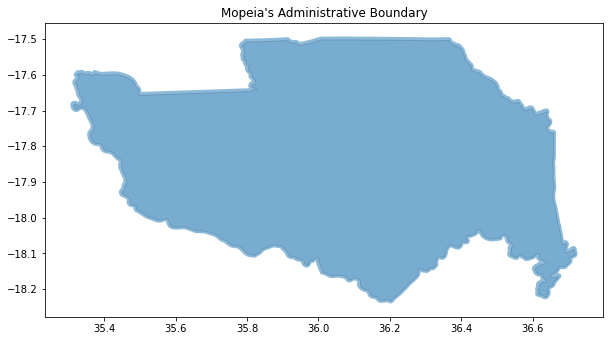

In [8]:
# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))
admin_gdf.plot(ax=ax, edgecolor='black', alpha=0.2)
admin_gdf_buf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5)
ax.set_aspect('equal', 'box')
txt = ax.set_title("{}'s Administrative Boundary".format(admin_gdf.ADM2_NAME.unique()[0]))

## Define the target locations (settlements/clusters)

Select the settlements to be used in the analysis

In [9]:
# Define path and name of the file
settles_path = in_path + "\\" + "Settlements"
#settles_name = "Mozambique_Settlement_Extents_Version_02.geojson"
settles_name = "Mopeia_clusters.shp"

In [10]:
## Read settlements as gdf
settles_gdf = gpd.read_file(settles_path + "\\" + settles_name)

In [11]:
##Activate this if you want to clip part of the AoI e.g., for testing
settles_gdf  = gpd.clip(settles_gdf, admin_gdf_buf)

### Filter clusters based on Building Count
Keeping clusters with more than 100 buildings

In [12]:
#settles_gdf.dtypes
settles_gdf["bld_count"].unique()

array(['251-1000', '101-250', '1001 and up'], dtype=object)

In [13]:
## If building count is an object you can use his to filter
settles_gdf = settles_gdf[(settles_gdf["bld_count"] == '101-250') | 
                          (settles_gdf["bld_count"] == '251-1000') | 
                          (settles_gdf["bld_count"] == '1001 and up')]

#If building count is numeric you can use his to filter
#settles_gdf = settles_gdf[settles_gdf["bld_count"] >= 100]

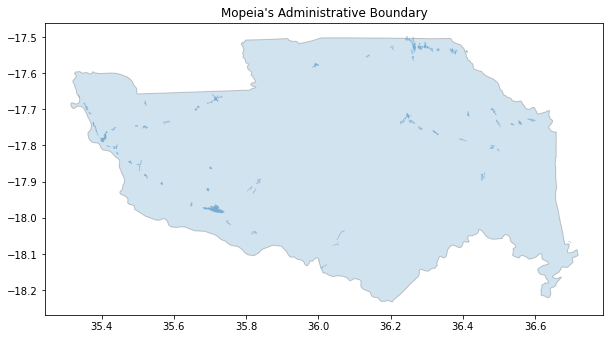

In [14]:
# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))
admin_gdf.plot(ax=ax, edgecolor='black', alpha=0.2)
settles_gdf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5)
ax.set_aspect('equal', 'box')
txt = ax.set_title("{}'s Administrative Boundary".format(admin_gdf.ADM2_NAME.unique()[0]))

### Raster population to clusters

In [15]:
settles_gdf = processing_raster("population", "sum", settles_gdf)
settles_gdf = finalizing_rasters(workspace, settles_gdf, crs_WGS84)

2024-08-15 15:36:38.428436
2024-08-15 15:36:38.998217


### Extracting RWI to clusters

Note that you can rasterize the csv file (as from HDX source) using the relevant .ipynb in the repo

In [16]:
settles_gdf = processing_raster("RWI", "mean", settles_gdf)
settles_gdf = finalizing_rasters(workspace, settles_gdf, crs_WGS84)

2024-08-15 15:36:50.270270
2024-08-15 15:36:50.856131


### Extracting animal headcount to clusters

In [17]:
animal_type = ["cattle", "chickens", "ducks", "goats", "pigs", "sheep", "horses", "buffaloes"]

In [18]:
for animal in animal_type:
    settles_gdf = processing_raster(animal, "sum", settles_gdf)
    
settles_gdf = finalizing_rasters(workspace, settles_gdf, crs_WGS84)

2024-08-15 15:37:48.019069
2024-08-15 15:37:52.272384
2024-08-15 15:37:56.551055
2024-08-15 15:38:00.687032
2024-08-15 15:38:06.307964
2024-08-15 15:38:11.510563
2024-08-15 15:38:15.668578
2024-08-15 15:38:19.489053
2024-08-15 15:38:20.064108


### Extracting HREA lightscore values to clusters

In [19]:
## Getting the average annual composite from VIIRS
settles_gdf = processing_raster("VIIRS", "mean" , settles_gdf)

## Extracting the max probability (lisghtscore) from the HREA layer
settles_gdf = processing_raster("HREA_lightscore", "max" , settles_gdf)

settles_gdf = finalizing_rasters(workspace, settles_gdf, crs_WGS84)

2024-08-15 15:38:50.604926
2024-08-15 15:39:03.066189
2024-08-15 15:39:03.644874


### Get accessibility

------------------------------------

**THIS IS WORK IN PROGRESS** --> For now we assume that the accessibility maps are already available via other methods

------------------------------------

**Note!** Accessibility maps can be retrieved using the other notebookes in this repository. More specifically:
* "Travel_time_maps.ipynb" will prepare the vector data as needed for
* "R-tool.ipynb", which prepares uses the [motorized friction surface layer](https://malariaatlas.org/project-resources/accessibility-to-healthcare/) and generates travel time maps for the locations of airports, ports, railways, major cities and the capital located in the "key_locations_for_Distance directory".

The above notebooks are preparatory and should be run before running this current .ipynb.

In [20]:
settles_gdf = processing_raster("access_airports", "mean", settles_gdf)
settles_gdf = processing_raster("access_ports", "mean", settles_gdf)
settles_gdf = processing_raster("access_railways", "mean", settles_gdf)
settles_gdf = processing_raster("access_cities", "mean", settles_gdf)
settles_gdf = processing_raster("access_capital", "mean", settles_gdf)
settles_gdf = finalizing_rasters(workspace, settles_gdf, crs_WGS84)

2024-08-15 15:40:05.143587
2024-08-15 15:40:11.019115
2024-08-15 15:40:15.683365
2024-08-15 15:40:20.629396
2024-08-15 15:40:24.530386
2024-08-15 15:40:25.126065


In [21]:
## Converting min to hours
settles_gdf['access_airportsmean'] = settles_gdf['access_airportsmean']/60
settles_gdf['access_portsmean'] = settles_gdf['access_portsmean']/60
settles_gdf['access_railwaysmean'] = settles_gdf['access_railwaysmean']/60
settles_gdf['access_citiesmean'] = settles_gdf['access_citiesmean']/60
settles_gdf['access_capitalmean'] = settles_gdf['access_capitalmean']/60

### Estimating Cooling requirements

In [22]:
settles_gdf = processing_raster("avg_temp", "mean", settles_gdf)
settles_gdf = finalizing_rasters(workspace, settles_gdf, crs_WGS84)
settles_gdf["CDD"] = (settles_gdf["avg_tempmean"] - 4)*365

2024-08-15 15:40:47.412573
2024-08-15 15:40:47.985547


### Fishing activity

In [23]:
## Adding a 10km buffer to the settlements layer
settles_gdf_buf = settles_gdf.copy()
settles_gdf_buf_prj = settles_gdf_buf.to_crs(crs_proj)
settles_gdf_buf_prj['geometry'] = settles_gdf_buf_prj.apply(lambda x:
                                                            x.geometry.buffer(10000, cap_style=3), axis=1)  ### ~10000m#
settles_gdf_buf = settles_gdf_buf_prj.to_crs(crs_WGS84)

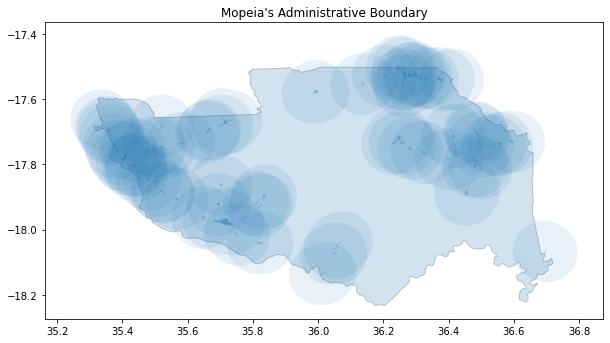

In [24]:
# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))
admin_gdf.plot(ax=ax, edgecolor='black', alpha=0.2)
settles_gdf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5)
settles_gdf_buf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.1)
ax.set_aspect('equal', 'box')
txt = ax.set_title("{}'s Administrative Boundary".format(admin_gdf.ADM2_NAME.unique()[0]))

#### Reclassifying raster 

In [25]:
WOraster = in_path + "\\" + "Water_Occurance" + "\\" + "Surface_Water_Occurance_2021_Mopeia.tif"
WOrasterreclass = in_path + "\\" + "Water_Occurance" + "\\" + "Surface_Water_Occurance_2021_Mopeia_reclass.tif"

In [26]:
## Reading the water occurance layer and reclasifying it keeping only values higher than 85 units
with rasterio.open(WOraster) as src:    
    # Read as numpy array
    array = src.read()
    profile = src.profile

    # Reclassify
    array[np.where(array <= 85)] = 0 
    #array[np.where(array == 2)] = 1
    # and so on ...  

with rasterio.open(WOrasterreclass, 'w', **profile) as dst:
    # Write to disk
    dst.write(array)

#### Extracting values to raster | merging with original settlements layer

In [27]:
settles_gdf_buf = processing_raster("water_occur", "sum", settles_gdf_buf)
settles_gdf_buf = finalizing_rasters(workspace, settles_gdf_buf, crs_WGS84)
settles_gdf = settles_gdf.merge(settles_gdf_buf[["id", 'water_occursum']], how="left", on='id')
settles_gdf['water_occursum'].fillna(0, inplace=True)

2024-08-15 15:41:39.058253
2024-08-15 15:41:39.162127


#### Classification of water occurrence values

In [28]:
## Binary classification of occurence values
settles_gdf['Water_Occur_Bin'] = settles_gdf['water_occursum'].apply(lambda x: 'Yes' if x > 0 else 'No')

# Qualitative classification based on quantiles
num_classes = 4
quantiles = np.linspace(0, 1, num_classes + 1)
quantile_values = settles_gdf['water_occursum'].quantile(quantiles)

def classify_occurrence(value, quantile_values):
    if value == 0:
        return 'No Occurrence'
    elif value <= quantile_values[0.25]:
        return 'Low Occurrence'
    elif value <= quantile_values[0.75]:
        return 'Medium Occurrence'
    else:
        return 'High Occurrence'

settles_gdf['Water_Occur_Clas'] = settles_gdf['water_occursum'].apply(classify_occurrence, args=(quantile_values,))

### Shorelines

In [29]:
# Define path and name of the file -- Using Resolution "f" and Level 1 as in documentation (here: https://www.ngdc.noaa.gov/mgg/shorelines/data/gshhg/latest/)--
shores_path = in_path + "\\" + "Shoreline"
shores_name = "Moz_Shoreline.gpkg"

In [30]:
## Read shores as gdf
shores_gdf = gpd.read_file(shores_path + "\\" + shores_name)

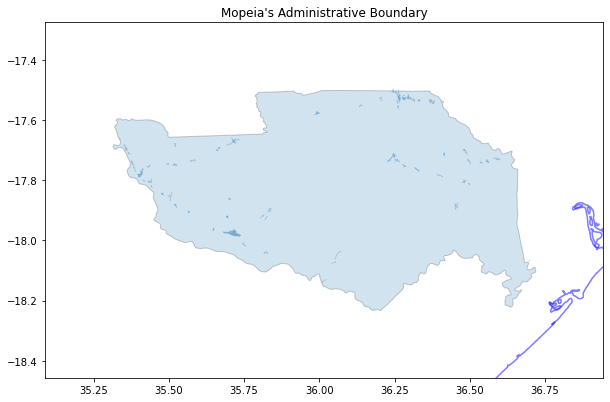

In [31]:
##Vizualize the shoreline in respect to the AoI
# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))
# Get the bounding box
xmin, ymin, xmax, ymax = admin_gdf.total_bounds
# Add a 50km buffer
buffer_size = 25  # in kilometers
# Convert buffer size from kilometers to degrees (assuming a spherical Earth)
buffer_degrees = buffer_size / 111.32  # Approximately 111.32 kilometers per degree at the equator
# Adjust the bounding box coordinates
xmin -= buffer_degrees
ymin -= buffer_degrees
xmax += buffer_degrees
ymax += buffer_degrees

admin_gdf.plot(ax=ax, edgecolor='black', alpha=0.2)
settles_gdf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5)
shores_gdf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5, edgecolor='blue', facecolor='none')

# Set the limits to zoom in on the specified bounding box
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_aspect('equal', 'box')
txt = ax.set_title("{}'s Administrative Boundary".format(admin_gdf.ADM2_NAME.unique()[0]))

In [32]:
settles_gdf = preparing_for_vectors_updated(workspace, settles_gdf, crs_proj)

2024-08-15 15:42:01.128903


In [33]:
settles_gdf = processing_shorelines("Shoreline", shores_gdf, crs_proj, workspace, settles_gdf)

2024-08-15 15:42:31.844951


In [34]:
## Binary classification of occurence values
settles_gdf['ShoreWithin10km'] = settles_gdf['ShorelineDist'].apply(lambda x: 'Yes' if x < 10 else 'No')

### Getting distance to nearest MV line

In [35]:
settles_gdf = processing_lines("MV_lines", admin_gdf, crs_proj, workspace, settles_gdf)

2024-08-15 15:43:02.079303


### Getting distance to nearest Service Transformer (TRX)

In [36]:
settles_gdf = processing_points("TRX", test_admin_gdf, crs_proj, workspace, settles_gdf, False)

2024-08-15 15:43:21.917522


### Electrification status classification 

In [37]:
TRX_dist_thres1 = 0.5
TRX_dist_thres2 = 1
MV_dist_thres1 = 0.5
MV_dist_thres2 = 1
mean_light_thres1 = 0.6
mean_light_thres2 = 0.4
mean_lightprob_thres1 = 0.8
mean_lightprob_thres2 = 0.5


def assign_elec_status(row):
    if (row["TRXDist"] < TRX_dist_thres1) and (row["MV_linesDist"] < MV_dist_thres1) and (row["VIRRSmean"] > mean_light_thres1) and (row["HREA_lightscoremax"] > mean_lightprob_thres1):
        return "electrified"
    elif (row["TRXDist"] < TRX_dist_thres2) and (row["MV_linesDist"] < MV_dist_thres2) and (row["VIRRSmean"] > mean_light_thres2) and (row["HREA_lightscoremax"] > mean_lightprob_thres2):
        return "likely electrified"
    else:
        return "un-electrified"
    
# Apply the function row-wise
settles_gdf["elec_status"] = settles_gdf.apply(assign_elec_status, axis=1)

### Food security

In [38]:
food_path = in_path + "\\" + "Food_Security"
food_name = "food_insecurity_IPC_May23_Mar24.gpkg"
food_gdf = gpd.read_file(food_path + "\\" + food_name)

In [39]:
food_gdf = cleaning_string_attributes(food_gdf, "area")

In [40]:
# Convert the DataFrame to a dictionary
food_sec_dict = {key: value for key, value in zip(food_gdf['area'], food_gdf['phase3_C_percentage'])}

In [41]:
settles_gdf = get_admin_name(settles_gdf, test_admin_gdf, "ADM2_NAME")

2024-08-15 15:43:41.357783


In [42]:
settles_gdf['Food_Sec'] = settles_gdf['ADM2_NAME'].map(food_sec_dict)

## Create Voronoi Polygons around settlements

In [43]:
vor_poly = createVoronoi(admin_gdf_buf, settles_gdf, crs_proj, crs_WGS84)

Boundary area defined..
Perimeter vertices generated..
Voronoi polygons generated..
Dissolved Voronoi polygons completed..


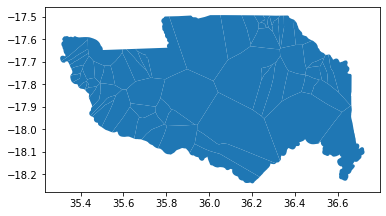

In [44]:
vor_poly.plot()

### Extracting Cropland extent

In [45]:
# Define path and name of the file
in_path_raster = in_path + "\\" + "Cropland"
cropland_name = "Global_cropland_SE_2019_Mopeia.tif"

In [46]:
# Calling the extraction function for discrete layers
vor_poly = processing_raster_cat(in_path_raster, cropland_name, "cropland", vor_poly)
vor_poly = finalizing_rasters(workspace, vor_poly, crs_proj)

cropland processing completed at 2024-08-15 15:55:26.888949
2024-08-15 15:55:27.009570


In [47]:
# Identify land cover related columns
final_list_of_cols = list(vor_poly.columns)
crop_cols = []
for col in final_list_of_cols:
    if "cropland" in col:
        crop_cols.append(col)
if not crop_cols:
    print ("There is not any Land Cover associated column in the dataframe; please revise")
else:
    pass

In [48]:
vor_poly = calc_Crop_sqkm(vor_poly, crop_cols)
vor_poly.rename({'cropland0':'No_crop_ha', 'cropland1':'Cropland_ha'}, axis=1, inplace=True)
vor_poly["Crop%"] = vor_poly['Cropland_ha']/vor_poly['Vor_area_ha']*100

In [49]:
vor_poly

,id,Vor_area_ha,Vor_area_sq.km,uniqueID,No_crop_ha,Cropland_ha,geometry,Crop%
0,420329,3370.888402,33.708884,69,3149.567446,221.320956,"POLYGON ((35.47006 -17.88445, 35.45013 -17.904...",6.565657
1,420504,1447.923169,14.479232,68,1326.621765,121.301405,"POLYGON ((35.46500 -17.82864, 35.46246 -17.831...",8.377613
2,421423,8175.687214,81.756872,384,8041.939738,133.747476,"POLYGON ((35.45013 -17.90497, 35.47006 -17.884...",1.635917
3,422404,3824.256977,38.242570,3232,3692.181527,132.075451,"POLYGON ((35.32956 -17.69939, 35.32710 -17.700...",3.453624
4,423418,2283.509379,22.835094,3198,2207.040572,76.468808,"MULTIPOLYGON (((35.36786 -17.70109, 35.36698 -...",3.348741
...,...,...,...,...,...,...,...,...
61,512919,4615.067886,46.150679,296,4611.947194,3.120692,"POLYGON ((36.48181 -17.60520, 36.46257 -17.613...",0.067620
62,512991,2737.154059,27.371541,8524,2736.071038,1.083021,"POLYGON ((36.32987 -17.62220, 36.33050 -17.631...",0.039567
63,513337,10140.299100,101.402991,1031,8798.285341,1342.013759,"POLYGON ((35.70632 -18.02192, 35.68469 -18.045...",13.234459
64,602105,14952.905333,149.529053,1182,14840.376645,112.528688,"POLYGON ((36.66423 -17.89400, 36.66097 -17.894...",0.752554


### Extracting harvested area

Here we are using a few sample crops, which of course can be expanded based on case study/need..

In [50]:
crop_types = ["rice", "maize", "cassava", "sorghum"]

In [51]:
for crop in crop_types:
    vor_poly = processing_raster(crop, "sum", vor_poly)
    
vor_poly = finalizing_rasters(workspace, vor_poly, crs_WGS84)

2024-08-15 16:04:09.114361
2024-08-15 16:04:15.238612
2024-08-15 16:04:21.481692
2024-08-15 16:04:26.892828
2024-08-15 16:04:27.045728


## Merging Voronoi to clusters

In [52]:
settles_gdf = settles_gdf.merge(vor_poly[['id',
                                          'Crop%', 
                                          'Cropland_ha', 
                                          'No_crop_ha', 
                                          'Vor_area_ha', 
                                          'Vor_area_sq.km',
                                          'ricesum', 
                                          'maizesum', 
                                          'cassavasum', 
                                          'sorghumsum']], how="left", on='id')

In [53]:
settles_gdf

,FID,HREA_lightscoremax,RWImean,SHAPE_Area,SHAPE_Leng,Shape_Le_1,VIIRSmean,access_airportsmean,access_capitalmean,access_citiesmean,...,Food_Sec,Crop%,Cropland_ha,No_crop_ha,Vor_area_ha,Vor_area_sq.km,ricesum,maizesum,cassavasum,sorghumsum
0,420330,0.279634,-0.287667,0.000044,0.051805,0.051805,0.110662,3.116482,18.526462,4.758549,...,NaN,6.565657,221.320956,3149.567446,3370.888402,33.708884,156.300003,389.400024,497.600006,56.299999
1,420505,0.261274,-0.352000,0.000023,0.030768,0.030768,0.219194,3.029637,18.438713,4.670798,...,NaN,8.377613,121.301405,1326.621765,1447.923169,14.479232,156.300003,389.400024,497.600006,56.299999
2,421424,0.408573,-0.425250,0.000075,0.168479,0.168479,0.093632,3.187710,18.597871,4.829957,...,NaN,1.635917,133.747476,8041.939738,8175.687214,81.756872,423.600006,1374.000000,1307.500000,221.299988
3,422405,0.231879,-0.614000,0.000024,0.043882,0.043882,0.184518,3.132306,18.592285,4.824371,...,NaN,3.453624,132.075451,3692.181527,3824.256977,38.242570,347.200012,1593.000000,915.099976,258.100006
4,423419,0.227336,-0.424000,0.000056,0.077457,0.077457,0.137862,3.110546,18.570525,4.802611,...,NaN,3.348741,76.468808,2207.040572,2283.509379,22.835094,401.800018,1804.500000,1136.199951,302.800018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,512920,0.228160,-0.405000,0.000099,0.180973,0.180973,0.103340,1.217007,19.874721,6.106807,...,0.2,0.067620,3.120692,4611.947194,4615.067886,46.150679,218.500000,90.500000,211.500000,13.300000
62,512992,0.241156,-0.416333,0.000086,0.165222,0.165222,0.085923,1.346204,19.735314,5.967399,...,NaN,0.039567,1.083021,2736.071038,2737.154059,27.371541,71.400002,148.300003,239.300003,7.600000
63,513338,3.208913,0.029500,0.000611,0.261357,0.261357,0.895509,3.253568,19.249476,5.481564,...,NaN,13.234459,1342.013759,8798.285341,10140.299100,101.402991,544.099976,1159.200073,971.299927,131.400009
64,602106,0.278368,-0.477500,0.000070,0.133468,0.133468,0.112845,3.029404,21.248421,7.480508,...,NaN,0.752554,112.528688,14840.376645,14952.905333,149.529053,89.599998,11.200000,38.600002,9.300000


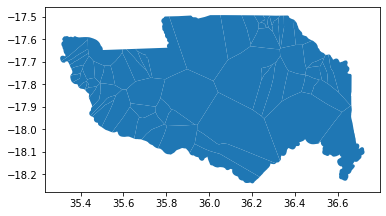

In [54]:
vor_poly.plot()

In [56]:
#vor_poly.to_file(workspace + r"\vor_poly.shp", driver='ESRI Shapefile')

## Compute indices

### Farming activity index
1. **Compute the farming activity, which is a proxy for farming activity based on:**
    - Farming volume: Cropland area within each settlement's influence area (Voronoi polygon)
    - Farming density: Percentage of each settlement's influence area (Voronoi polygon) occupied by crops


2. **Normalize the index using min-max scaling**

3. **Reduce Skeweness**

count    66.000000
mean      0.516775
std       0.210637
min       0.000000
25%       0.361478
50%       0.508231
75%       0.671484
max       1.000000
Name: farming_activity_n, dtype: float64

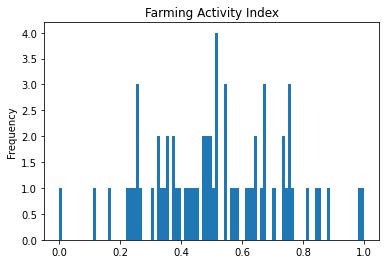

In [66]:
#Calculating farming activity index based on surrounding cropland area and cropland area percentage
w_croplnd_area_ha=0.5
w_croplnd_area_perc=0.5
settles_gdf['farming_activity']= (
    (settles_gdf['Cropland_ha'] - settles_gdf['Cropland_ha'].min())/(settles_gdf['Cropland_ha'].max() - settles_gdf['Cropland_ha'].min())*w_croplnd_area_ha
    + (settles_gdf['Crop%'] - settles_gdf['Crop%'].min())/(settles_gdf['Crop%'].max() - settles_gdf['Crop%'].min())*w_croplnd_area_perc
)
7
## Normalize
scaler = MinMaxScaler()
settles_gdf['farming_activity_n']= scaler.fit_transform(settles_gdf[['farming_activity']])

## Reduce skeweness
settles_gdf['farming_activity_n']=np.power((settles_gdf['farming_activity_n']),1/4)

## Visualize plot and desctiptive analytics

settles_gdf['farming_activity_n'].plot.hist(bins=100, title='Farming Activity Index')
settles_gdf['farming_activity_n'].describe()

## Market accessibility index

**Compute the market accessibility, which is a proxy for the possibility to trade or export agricultural products based on a weighted average of:**
    - travel time to the capital city (potential for export and national distribution)
    - travel time to major cities (potential for sales in fresh markets and national distribution)
    - travel time to ports (potential for export)
    - travel time to railway stations (potential for export and national distribution)
    - travel time to airports (potential for export and national distribution)
    - population sum within 20 km radius (potential for sales in fresh markets)
    - farming density: Percentage of each settlement's influence area (Voronoi polygon) occupied by crops



1. Normalize the accessibility parameters using min-max scaling

In [69]:
#Normalization of accessibility parameters
""" scaler = MinMaxScaler()
settles_gdf['travel_to_capital_n'] = scaler.fit_transform(settles_gdf[['access_capitalmean']])
settles_gdf['travel_maj_city_200k_n'] = scaler.fit_transform(settles_gdf[['access_citiesmean']])
settles_gdf['travel_to_railw_n'] = scaler.fit_transform(settles_gdf[['access_railwaysmean']])
settles_gdf['travel_to_airports_n'] = scaler.fit_transform(settles_gdf[['access_airportsmean']])
settles_gdf['travel_to_ports_n'] = scaler.fit_transform(settles_gdf[['access_portsmean']])
settles_gdf['pop_20km_buffer_n'] = scaler.fit_transform(settles_gdf[['populationsum']])
settles_gdf """


settles_gdf['travel_to_capital_n'] = (settles_gdf['access_capitalmean'].max()-settles_gdf['access_capitalmean'])/(settles_gdf['access_capitalmean'].max()-settles_gdf['access_capitalmean'].min())
settles_gdf['travel_to_railw_n'] = (settles_gdf['access_railwaysmean'].max()-settles_gdf['access_railwaysmean'])/(settles_gdf['access_railwaysmean'].max()-settles_gdf['access_railwaysmean'].min())
settles_gdf['travel_to_ports_n'] = (settles_gdf['access_portsmean'].max()-settles_gdf['access_portsmean'])/(settles_gdf['access_portsmean'].max()-settles_gdf['access_portsmean'].min())
settles_gdf['travel_to_airports_n'] = (settles_gdf['access_airportsmean'].max()-settles_gdf['access_airportsmean'])/(settles_gdf['access_airportsmean'].max()-settles_gdf['access_airportsmean'].min())
settles_gdf['travel_maj_city_200k_n'] = (settles_gdf['access_citiesmean'].max()-settles_gdf['access_citiesmean'])/(settles_gdf['access_citiesmean'].max()-settles_gdf['access_citiesmean'].min())
settles_gdf['pop_20km_buffer_n'] = (settles_gdf['populationsum']-settles_gdf['populationsum'].min())/(settles_gdf['populationsum'].max()-settles_gdf['populationsum'].min())
pd.set_option('display.max_columns', None)
#settles_gdf

2. Assign weights, normalize weights, calculate weighted average, normalize the index

count    66.000000
mean      0.544144
std       0.207734
min       0.000000
25%       0.454849
50%       0.581829
75%       0.694668
max       1.000000
Name: access_farm_index_n, dtype: float64

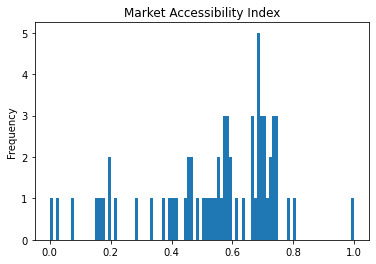

In [73]:
## Setting weights from 0 to 100
w_travel_to_capital=5
w_travel_to_railw=20
w_travel_to_air=50
w_travel_to_port=70
w_travel_to_maj_city=100
w_pop20km=100

## Normalizing weights
weights=np.array([w_travel_to_capital, w_travel_to_railw, w_travel_to_air, w_travel_to_port, w_travel_to_maj_city, w_pop20km])
total_weights = np.sum(weights)
w_travel_to_capital=w_travel_to_capital/total_weights
w_travel_to_railw=w_travel_to_railw/total_weights
w_travel_to_air=w_travel_to_air/total_weights
w_travel_to_port=w_travel_to_port/total_weights
w_travel_to_maj_city=w_travel_to_maj_city/total_weights
w_pop20km=w_pop20km/total_weights

## Calculating accessibility indicator for farming activity, i.e. proxy for the ability to sell agricultural outputs
access_farm_index=(
    w_travel_to_capital*settles_gdf['travel_to_capital_n']+
    w_travel_to_railw*settles_gdf['travel_to_railw_n']+
    w_travel_to_air*settles_gdf['travel_to_airports_n']+
    w_travel_to_port*settles_gdf['travel_to_ports_n']+
    w_travel_to_maj_city*settles_gdf['travel_maj_city_200k_n']+
    w_pop20km*settles_gdf['pop_20km_buffer_n']
)
settles_gdf['access_farm_index']=access_farm_index

## Normalize access_farm_index
access_farm_index_n= (settles_gdf['access_farm_index'] - settles_gdf['access_farm_index'].min()) / (settles_gdf['access_farm_index'].max() - settles_gdf['access_farm_index'].min())

""" scaler = MinMaxScaler()
access_farm_index_n = scaler.fit_transform(settles_gdf['access_farm_index'].values.reshape(-1, 1)).flatten()
 """
settles_gdf['access_farm_index_n'] = access_farm_index_n
settles_gdf['access_farm_index_n'].plot.hist(bins=100, title='Market Accessibility Index')
settles_gdf['access_farm_index_n'].describe()

#reduce skewness (no need here)
#settles_gdf['access_farm_index_n']=np.power((settles_gdf['access_farm_index_n']),1)

#settles_gdf.head(100)

## Market potential index
**Compute the market potential, which is a proxy for the settlement's ability to both produce and trade agricultural products, based on a weighted average of:**
    - farming activity
    - market accessibility

count    66.000000
mean      0.484402
std       0.188358
min       0.000000
25%       0.380491
50%       0.522326
75%       0.612522
max       1.000000
Name: mrkt_potential_n, dtype: float64

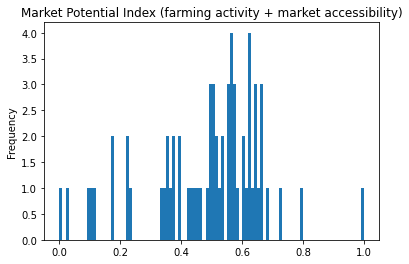

In [76]:
## Assign weights to the importance of farming activity Vs market accessibility
farm_activity_weight = 0.4
market_access_weight = 0.6

settles_gdf['mrkt_potential'] = settles_gdf['access_farm_index_n']*market_access_weight + settles_gdf['farming_activity_n']*farm_activity_weight

## Normalize
settles_gdf['mrkt_potential_n'] = scaler.fit_transform(settles_gdf['mrkt_potential'].values.reshape(-1, 1)).flatten()
settles_gdf['mrkt_potential_n'].plot.hist(bins=100, title='Market Potential Index (farming activity + market accessibility)')
#settles_gdf.plot.scatter(y='mrkt_potential_n', x='farming_activity_n')
#settles_gdf.plot.scatter(y='mrkt_potential_n', x='access_farm_index_n')

settles_gdf['mrkt_potential_n'].describe()

## Inland fish market accessibility index

**Compute the inland fish market accessibility, which is a proxy for the possibility to trade or export products based on a weighted average of:**
    - Inland water occurrence 
    - travel time to ports (potential for export)
    - travel time to railway stations (potential for export and national distribution)
    - travel time to airports (potential for export and national distribution)
    - population sum within 20 km radius (potential for sales in fresh markets)

1. Normalize the inland water occurrence parameter using min-max scaling

In [82]:
settles_gdf['water_occursum_n'] = (settles_gdf['water_occursum'].max()-settles_gdf['water_occursum'])/(settles_gdf['water_occursum'].max()-settles_gdf['water_occursum'].min())

2. Assign weights, normalize weights, calculate weighted average, normalize the index

count    66.000000
mean      0.539964
std       0.273783
min       0.000000
25%       0.375510
50%       0.601712
75%       0.742591
max       1.000000
Name: inland_water_index_n, dtype: float64

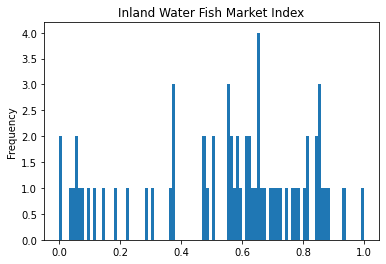

In [84]:
## Setting weights from 0 to 100
w_ineater_occur=90
w_travel_to_railw=5
w_travel_to_air=25
w_travel_to_port=50
w_pop20km=100

## Normalizing weights
weights=np.array([w_ineater_occur, w_travel_to_railw, w_travel_to_air, w_travel_to_port, w_pop20km])
total_weights = np.sum(weights)

w_ineater_occur=w_ineater_occur/total_weights
w_travel_to_railw=w_travel_to_railw/total_weights
w_travel_to_air=w_travel_to_air/total_weights
w_travel_to_port=w_travel_to_port/total_weights
w_pop20km=w_pop20km/total_weights

## Calculating accessibility indicator for farming activity, i.e. proxy for the ability to sell agricultural outputs
inland_water_index=(
    w_ineater_occur*settles_gdf['water_occursum_n']+
    w_travel_to_railw*settles_gdf['travel_to_railw_n']+
    w_travel_to_air*settles_gdf['travel_to_airports_n']+
    w_travel_to_port*settles_gdf['travel_to_ports_n']+
    w_pop20km*settles_gdf['pop_20km_buffer_n']
)

settles_gdf['inland_water_index']=inland_water_index

## Normalize access_farm_index
inland_water_index_n= (settles_gdf['inland_water_index'] - settles_gdf['inland_water_index'].min()) / (settles_gdf['inland_water_index'].max() - settles_gdf['inland_water_index'].min())

""" scaler = MinMaxScaler()
inland_water_index_n = scaler.fit_transform(settles_gdf['inland_water_index'].values.reshape(-1, 1)).flatten()
 """
settles_gdf['inland_water_index_n'] = inland_water_index_n
settles_gdf['inland_water_index_n'].plot.hist(bins=100, title='Inland Water Fish Market Index') 
settles_gdf['inland_water_index_n'].describe()

#reduce skewness (no need here)
#settles_gdf['inland_water_index_n']=np.power((settles_gdf['inland_water_index_n']),1)

#settles_gdf.head(100)

## Marine fish market accessibility index

**Compute the marine fish market accessibility, which is a proxy for the possibility to trade or export products based on a weighted average of:**
    - Distance to shoreline 
    - travel time to ports (potential for export)
    - travel time to railway stations (potential for export and national distribution)
    - travel time to airports (potential for export and national distribution)
    - population sum within 20 km radius (potential for sales in fresh markets) 

1. Normalize the distance to shoreline parameter using min-max scaling

In [85]:
settles_gdf['ShorelineDist_n'] = (settles_gdf['ShorelineDist'].max()-settles_gdf['ShorelineDist'])/(settles_gdf['ShorelineDist'].max()-settles_gdf['ShorelineDist'].min())

2. Assign weights, normalize weights, calculate weighted average, normalize the index

count    66.000000
mean      0.387132
std       0.227436
min       0.000000
25%       0.176354
50%       0.385062
75%       0.561382
max       1.000000
Name: marine_water_index_n, dtype: float64

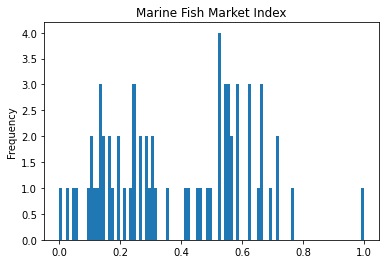

In [87]:
## Setting weights from 0 to 100
w_shore_dist=90
w_travel_to_railw=5
w_travel_to_air=25
w_travel_to_port=50
w_pop20km=70

## Normalizing weights
weights=np.array([w_shore_dist, w_travel_to_railw, w_travel_to_air, w_travel_to_port, w_pop20km])
total_weights = np.sum(weights)

w_shore_dist=w_shore_dist/total_weights
w_travel_to_railw=w_travel_to_railw/total_weights
w_travel_to_air=w_travel_to_air/total_weights
w_travel_to_port=w_travel_to_port/total_weights
w_pop20km=w_pop20km/total_weights

## Calculating accessibility indicator for farming activity, i.e. proxy for the ability to sell agricultural outputs
marine_water_index=(
    w_shore_dist*settles_gdf['ShorelineDist_n']+
    w_travel_to_railw*settles_gdf['travel_to_railw_n']+
    w_travel_to_air*settles_gdf['travel_to_airports_n']+
    w_travel_to_port*settles_gdf['travel_to_ports_n']+
    w_pop20km*settles_gdf['pop_20km_buffer_n']
)

settles_gdf['marine_water_index']=marine_water_index

## Normalize access_farm_index
marine_water_index_n= (settles_gdf['marine_water_index'] - settles_gdf['marine_water_index'].min()) / (settles_gdf['marine_water_index'].max() - settles_gdf['marine_water_index'].min())

""" scaler = MinMaxScaler()
marine_water_index_n = scaler.fit_transform(settles_gdf['marine_water_index'].values.reshape(-1, 1)).flatten()
 """
settles_gdf['marine_water_index_n'] = marine_water_index_n
settles_gdf['marine_water_index_n'].plot.hist(bins=100, title='Marine Fish Market Index') 
settles_gdf['marine_water_index_n'].describe()

#reduce skewness (no need here)
#settles_gdf['marine_water_index_n']=np.power((settles_gdf['marine_water_index_n']),1)

#settles_gdf.head(100)

## Fish market potential index
**Compute the fish market potential, which is a proxy for the settlement's ability to both produce and trade fishing products, based on a weighted average of:**
    - Inland water fishing activity
    - Marine fishing activity

count    66.000000
mean      0.476798
std       0.268607
min       0.000000
25%       0.289901
50%       0.475674
75%       0.671294
max       1.000000
Name: fish_mrkt_potential_n, dtype: float64

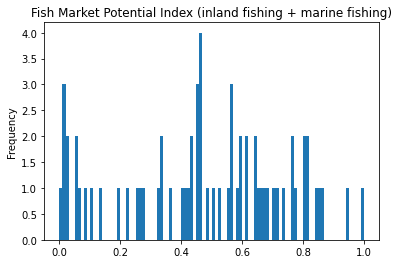

In [89]:
## Assign weights to the importance of inland water Vs marine fishing activity
inland_fish_weight = 0.5
marine_fish_weight = 0.5

settles_gdf['fish_mrkt_potential'] = settles_gdf['inland_water_index_n']*inland_fish_weight + settles_gdf['marine_water_index_n']*marine_fish_weight

## Normalize
settles_gdf['fish_mrkt_potential_n'] = scaler.fit_transform(settles_gdf['fish_mrkt_potential'].values.reshape(-1, 1)).flatten()
settles_gdf['fish_mrkt_potential_n'].plot.hist(bins=100, title='Fish Market Potential Index (inland fishing + marine fishing)')

settles_gdf['fish_mrkt_potential_n'].describe()

In [58]:
for i in settles_gdf.columns:
    print(i)

FID
HREA_lightscoremax
RWImean
SHAPE_Area
SHAPE_Leng
Shape_Le_1
VIIRSmean
access_airportsmean
access_capitalmean
access_citiesmean
access_portsmean
access_railwaysmean
area_m2
bld_count
buffaloessum
cattlesum
chickenssum
country
date
dou_level1
dou_level2
duckssum
goatssum
horsessum
id
is_fp
iso
mgrs
pcode
pigssum
population
populationsum
prob_fp
sheepsum
status
avg_tempmean
geometry
CDD
water_occursum
Water_Occur_Bin
Water_Occur_Clas
ShorelineDist
ShoreWithin10km
MV_linesDist
TRXDist
elec_status
ADM2_NAME
Food_Sec
Crop%
Cropland_ha
No_crop_ha
Vor_area_ha
Vor_area_sq.km
ricesum
maizesum
cassavasum
sorghumsum


In [80]:
settles_gdf.water_occursum.describe()

count        66.000000
mean     208663.469697
std      331346.989069
min           0.000000
25%           0.000000
50%           0.000000
75%      392585.250000
max      984381.000000
Name: water_occursum, dtype: float64

# TBD..